#### PRNG evolution analysis with prediction attacks

In [1]:
#Basic imports for now

# NN-Tools
import numpy as np 
import keras 

# Visualization
from IPython.display import SVG 
from IPython.display import display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Printing
from sympy import *
init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# custom tooling for seeding and PRNG
from PRNGs import *
from SeedGenerator import *

# for data normalization
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# Generation Parameters: Generate y sets of length z
NumberofSets = 1000
LengthofEachSet = 1000

# train and test data inits
x_train = []
y_train = []

x_test = []
y_test = []

# Description:
# This function invokes the PRNG and obtains y sets of length z. 
# Each set has its own seed, obtained from our custom SeedGenerator
# It then splices the last number in a set off and appends
# n-1 to x (for x_train or test) and the nth to y (for y_train or test)
# Params:
# x: gets the first n-1 values of each set
# y: gets the nth value of the set
# numsets: represents the amount of sets
# setlength: represents length of each set
def aggregate_and_split(x,y, numsets, setlength):
    temp = []
    for i in range(numsets):
        t = ticks()
        temp = Middle_Square(t,setlength)
        for a in range(len(temp)): #little expensive
            temp[a] = int(temp[a])
        n = temp[-1]
        y.append(n)
        x.append(temp[:-1])
             
#### set up training data: ####
aggregate_and_split(x_train, y_train, NumberofSets, LengthofEachSet)

#normalize data to prevent weight values overflowing (NaN) and convert to np.array
x_train = preprocessing.normalize(np.array(x_train))
y_train = preprocessing.normalize(np.array([y_train]))

y_train = y_train.flatten() #ravel will be more efficient if we don't need to modify.


#### set up testing data: ####
aggregate_and_split(x_test, y_test, 1000, 1000)
x_test = preprocessing.normalize(np.array(x_test))
y_test = preprocessing.normalize(np.array([y_test]))

#normalize data to prevent weight values overflowing (NaN) and convert to np.array
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_test = y_test.flatten() #ravel will be more efficient if we don't need to modify.


#various prints:
print(x_train.shape)
print(y_train.shape)
#print(x_train)
#print(y_train)

#print(x_test)
#print(x_test.shape)
#print(y_test.shape)


(1000, 999, 1)
(1000,)


In [3]:
# Description:
# This function sets up the model and returns a keras sequential model.
# Params:
# input_width: the size of the input layer
# output_width: the size of the output layer
def predictor(input_width, output_width):
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(3, 3,
                                activation='relu',
                                input_shape=(input_width, 1),
                                name='conv_1'
                             )
         )
    model.add(keras.layers.Conv1D(4, 2, activation='relu', name='conv_2'))
    model.add(keras.layers.Conv1D(20, 10, activation='relu', name='conv_3'))
    model.add(keras.layers.Conv1D(50, 5, activation='relu', name='conv_4'))
    model.add(keras.layers.MaxPool1D(1, 1, name='maxpool_1'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten(name='flatten_1'))
    model.add(keras.layers.Dense(4, activation='relu', name='dense_1'))
    model.add(keras.layers.Dense(output_width, activation='relu', name='dense_2'))    
    return model

mod = predictor(x_train.shape[1],1)
          
mod.compile(loss='mean_squared_error', optimizer='adam')
mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 997, 3)            12        
_________________________________________________________________
conv_2 (Conv1D)              (None, 996, 4)            28        
_________________________________________________________________
conv_3 (Conv1D)              (None, 987, 20)           820       
_________________________________________________________________
conv_4 (Conv1D)              (None, 983, 50)           5050      
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 983, 50)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 983, 50)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 49150)            

In [4]:
batch_size=10
epochs=100
#history=mod.fit(x_train,y_train,batch_size=batch_size,epochs=epochs, validation_split=0.1,verbose=1, validation_data=(x_test, y_test))
history=mod.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=0)

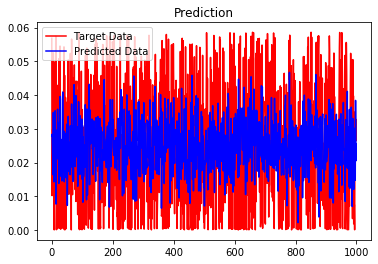

(1000,)
(1000,)
Pearson Correlation Coefficient: 0.036020348458091225
2-tailed p-value:                 0.2551171060148085


In [5]:
from scipy.stats.stats import pearsonr 
y_pred = mod.predict(x_test)
y_actual = y_test
#mod.predict(x_test[0])

plt.plot(y_actual, color = 'red', label = 'Target Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted Data')
plt.title('Prediction')
plt.legend()
plt.show()

y_pred = y_pred.flatten()

print(y_actual.shape)
print(y_pred.shape)



pearsoncorr = pearsonr(y_actual,y_pred)
print("Pearson Correlation Coefficient:", pearsoncorr[0])
print("2-tailed p-value:                ", pearsoncorr[1])


In [6]:
#deprecated for now .........

#scores = mod.evaluate(x_test, y_test, verbose=1)

#scores[1]
'''
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
# summarize history for loss  
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()
'''
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Reshape
'''
#initially using fewer kernels and increasing gradually while monitoring the error rate on how it is varying
model = keras.Sequential()
model.add(Reshape((x.shape[1], 1), input_shape=(x.shape[1], )))
model.add(keras.layers.Conv1D(98, kernel_size=2,
                                activation='relu',
                                input_shape=(1,98)
                             )
         )
        
        
#data work in progress
          
model.add(keras.layers.Conv1D(64, 2, activation='relu'))
model.add(keras.layers.Conv1D(64, 2, activation='relu'))
model.add(keras.layers.Conv1D(64, 2, activation='relu'))

#test pool size and monitor what works better

model.add(keras.layers.MaxPooling1D(pool_size=(4)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dropout(0.5))
          
          
model.add(keras.layers.Dense(1, activation='softmax'))
          
    #data work in progress
          
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])
          
model.summary()
          
'''    


"\n#initially using fewer kernels and increasing gradually while monitoring the error rate on how it is varying\nmodel = keras.Sequential()\nmodel.add(Reshape((x.shape[1], 1), input_shape=(x.shape[1], )))\nmodel.add(keras.layers.Conv1D(98, kernel_size=2,\n                                activation='relu',\n                                input_shape=(1,98)\n                             )\n         )\n        \n        \n#data work in progress\n          \nmodel.add(keras.layers.Conv1D(64, 2, activation='relu'))\nmodel.add(keras.layers.Conv1D(64, 2, activation='relu'))\nmodel.add(keras.layers.Conv1D(64, 2, activation='relu'))\n\n#test pool size and monitor what works better\n\nmodel.add(keras.layers.MaxPooling1D(pool_size=(4)))\nmodel.add(keras.layers.Dropout(0.25))\nmodel.add(keras.layers.Flatten())\nmodel.add(keras.layers.Dense(4, activation='relu'))\nmodel.add(keras.layers.Dropout(0.5))\n          \n          \nmodel.add(keras.layers.Dense(1, activation='softmax'))\n          \n    #